In [1]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from tqdm import tqdm

In [2]:
import sys
print(sys.path)

# sys.path.append('/home/jw6254/anaconda3/envs/keras-test/lib/python3.7/site-packages/')

['/scratch/jw6254/myjupyter', '/home/jw6254/anaconda3/envs/keras/lib/python37.zip', '/home/jw6254/anaconda3/envs/keras/lib/python3.7', '/home/jw6254/anaconda3/envs/keras/lib/python3.7/lib-dynload', '', '/home/jw6254/anaconda3/envs/keras/lib/python3.7/site-packages', '/home/jw6254/anaconda3/envs/keras/lib/python3.7/site-packages/IPython/extensions', '/home/jw6254/.ipython']


In [4]:
import keras

In [5]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

## Dataset

In [6]:
import pickle

file_path_1 = '/scratch/jw6254/unziptest/pkl_files/log_mel_spec.pkl'
file_path_2 = '/scratch/jw6254/unziptest/pkl_files/noisy_log_mel_spec.pkl'
file_path_3 = '/scratch/jw6254/unziptest/pkl_files/shuffled_log_mel_spec.pkl'

with open(file_path_1, 'rb') as handle:
    anchor_list = pickle.load(handle)
    
with open(file_path_2, 'rb') as handle:
    positive_list = pickle.load(handle)
    
with open(file_path_3, 'rb') as handle:
    negative_list = pickle.load(handle)


In [27]:

def cleaning_func(anchor_list, positive_list, negative_list):
    """
    Some entries are incorrect shapes from the spectogram creation, so removing those entries
    """
    break_counter = 0
    cleaned_anchor_list = []
    cleaned_positive_list = []
    cleaned_negative_list = []
    for i in range(len(anchor_list)):
        if anchor_list[i].shape == (128, 2000) and positive_list[i].shape == (128,2000) and negative_list[i].shape == (128,2000):
            cleaned_anchor_list.append(anchor_list[i])
            cleaned_positive_list.append(positive_list[i])
            cleaned_negative_list.append(negative_list[i])
        else: 
            break_counter+=1
    return cleaned_anchor_list, cleaned_positive_list, cleaned_negative_list, break_counter
    

In [29]:
anchor_list_cleaned, positive_list_cleaned, negative_list_cleaned, num_excluded = cleaning_func(anchor_list, positive_list, negative_list)

In [31]:
len(anchor_list_cleaned), len(positive_list_cleaned), len(negative_list_cleaned), num_excluded

(7963, 7963, 7963, 34)

## Train and Validation Sets
The data is already shuffled

In [33]:
train_set_size = 7000

achor_train_list = anchor_list_cleaned[:train_set_size]
positive_train_list = positive_list_cleaned[:train_set_size]
negative_train_list = negative_list_cleaned[:train_set_size]

achor_validation_list = anchor_list_cleaned[train_set_size:7950]
positive_validation_list = positive_list_cleaned[train_set_size:7950]
negative_validation_list = negative_list_cleaned[train_set_size:7950]

## Batch Function

In [35]:
def batch_and_sampling(anchor, positive, negative, num_batches, x_size, y_size):
    """
    
    Function that creates the necessary data structure to be inputted into the model.
    This function also takes in random sampling paramters to compress the size of the 
    inputted spectograms. 
    
    """
    n_rows = anchor[0].shape[0]
    n_cols = anchor[0].shape[1]
    
    batch_size = int(len(anchor) / num_batches)

    total_list = []
    for i in tqdm(range(num_batches)):

        mini_batch_anchor = np.zeros((batch_size, x_size, y_size, 1))
        mini_batch_positive = np.zeros((batch_size, x_size, y_size, 1))
        mini_batch_negative = np.zeros((batch_size, x_size, y_size, 1))
        for j in range(len(anchor[i::num_batches])):
            random_indices_rows = np.random.choice(n_rows, size=x_size, replace=False)
            random_indices_cols = np.random.choice(n_cols, size=y_size, replace=False)

            temp_anchor = anchor[i::num_batches][j][random_indices_rows, :][:, random_indices_cols]
            temp_positive = positive[i::num_batches][j][random_indices_rows, :][:, random_indices_cols]
            temp_negative = negative[i::num_batches][j][random_indices_rows, :][:, random_indices_cols]

            anc = np.reshape(temp_anchor, (1, x_size, y_size, 1))
            pos = np.reshape(temp_positive, (1, x_size, y_size, 1))
            neg = np.reshape(temp_negative, (1, x_size, y_size, 1))

            mini_batch_anchor[j] = anc
            mini_batch_positive[j] = pos
            mini_batch_negative[j] = neg
        total_list.append([mini_batch_anchor, mini_batch_positive, mini_batch_negative])
        
    return total_list

In [16]:
# Want Each Batch to have 50 Elements
# num_of_batches = int(train_set_size/50)
# reduced_x_dim = 50
# reduced_y_dim = 50

# batched = batch_and_sampling(anchor_list, positive_list, negative_list, num_of_batches, reduced_x_dim, reduced_y_dim)

## Creating Batches for Training and Validation Data

In [36]:
test_num_of_batches = int(train_set_size/50)
test_reduced_x_dim = 50
test_reduced_y_dim = 50

train_batched = batch_and_sampling(achor_train_list,
                                   positive_train_list,
                                   negative_train_list, 
                                   test_num_of_batches, 
                                   test_reduced_x_dim, 
                                   test_reduced_y_dim)

100%|██████████| 140/140 [00:26<00:00,  5.20it/s]


In [37]:
# Checking dim of training data 
len(train_batched), [j.shape for j in train_batched[0]]

(140, [(50, 50, 50, 1), (50, 50, 50, 1), (50, 50, 50, 1)])

In [66]:
test_num_of_batches_val = int(len(achor_validation_list)/50)

test_val_batched = batch_and_sampling(achor_validation_list,
                                      positive_validation_list,
                                      neagtive_validation_list, 
                                      test_num_of_batches_val, 
                                      test_reduced_x_dim, 
                                      test_reduced_y_dim)

100%|██████████| 19/19 [00:04<00:00,  3.86it/s]


In [67]:
# Checking dim of validation data 
len(test_val_batched), [j.shape for j in test_val_batched[0]]

(19, [(50, 50, 50, 1), (50, 50, 50, 1), (50, 50, 50, 1)])

## Comparing Original Spectogram Dimnensions with Reduced Dimensions

For computational purposes, having a spectogram that is 128x2000 is untenable with the given resources. To solve this problem, I randomly sample 50 rows and columns so the inputted spectogram to the model is much smaller.

In [42]:
input_shape = train_batched[0][0][0].shape

print("Original Spectogram Dimensions: ", anchor_list[0].shape)
print("Randomly Sampled Spectogram Dimensions: ", input_shape[:2])

Original Spectogram Dimensions:  (128, 2000)
Randomly Sampled Spectogram Dimensions:  (50, 50)


### Build Neural Network for computing triplet similarity

In [44]:
def build_network(input_shape, embeddingsize):
    # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (3,3), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
    # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

## Define the Network

In [46]:
network = build_network(input_shape,embeddingsize=10)
network_train = build_model(input_shape,network)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True,)
# print(network_train.metrics_names)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 10)           85423754    anchor_input[0][0]               
                                                                 positive_input[0][0]       

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

## Simple Function to Train Network

In [51]:
def run_training(num_epochs, batched_data):
    print("Starting training process!")
    print("-------------------------------------")
    t_start = time.time()

    loss_list = []
    for i in tqdm(range(1, num_epochs+1)):
        print("--------- Epoch: ", i, "---------")
        loss_per_batch = 0
        for j in range(len(batched_data)):
            loss = network_train.train_on_batch(batched_data[i], None)
            loss_per_batch+=loss

            print("Epoch: ", i, "Batch: ", j, "Batch Loss: ", loss)
        loss_list.append(loss_per_batch/len(batched_data))
        print("\n")
        
    return loss_list

## Training

In [52]:
train_losses = run_training(5, train_batched)

  0%|          | 0/5 [00:00<?, ?it/s]

Starting training process!
-------------------------------------
--------- Epoch:  1 ---------
Epoch:  1 Batch:  0 Batch Loss:  13.587622
Epoch:  1 Batch:  1 Batch Loss:  10.605847
Epoch:  1 Batch:  2 Batch Loss:  9.6472435
Epoch:  1 Batch:  3 Batch Loss:  9.099962
Epoch:  1 Batch:  4 Batch Loss:  8.713344
Epoch:  1 Batch:  5 Batch Loss:  8.483437
Epoch:  1 Batch:  6 Batch Loss:  8.3858385
Epoch:  1 Batch:  7 Batch Loss:  8.294691
Epoch:  1 Batch:  8 Batch Loss:  8.2747135
Epoch:  1 Batch:  9 Batch Loss:  8.254504
Epoch:  1 Batch:  10 Batch Loss:  8.234111
Epoch:  1 Batch:  11 Batch Loss:  8.213576
Epoch:  1 Batch:  12 Batch Loss:  8.197214
Epoch:  1 Batch:  13 Batch Loss:  8.172367
Epoch:  1 Batch:  14 Batch Loss:  8.151741
Epoch:  1 Batch:  15 Batch Loss:  8.131076
Epoch:  1 Batch:  16 Batch Loss:  8.110387
Epoch:  1 Batch:  17 Batch Loss:  8.089688
Epoch:  1 Batch:  18 Batch Loss:  8.068994
Epoch:  1 Batch:  19 Batch Loss:  8.048316
Epoch:  1 Batch:  20 Batch Loss:  8.027663
Epoch: 

 20%|██        | 1/5 [20:14<1:20:56, 1214.01s/it]

Epoch:  1 Batch:  139 Batch Loss:  6.2172465


--------- Epoch:  2 ---------
Epoch:  2 Batch:  0 Batch Loss:  10.155866
Epoch:  2 Batch:  1 Batch Loss:  8.691364
Epoch:  2 Batch:  2 Batch Loss:  7.047375
Epoch:  2 Batch:  3 Batch Loss:  6.4786716
Epoch:  2 Batch:  4 Batch Loss:  6.2712283
Epoch:  2 Batch:  5 Batch Loss:  6.1647296
Epoch:  2 Batch:  6 Batch Loss:  6.1914587
Epoch:  2 Batch:  7 Batch Loss:  6.2807817
Epoch:  2 Batch:  8 Batch Loss:  6.3956704
Epoch:  2 Batch:  9 Batch Loss:  6.1801267
Epoch:  2 Batch:  10 Batch Loss:  6.1270676
Epoch:  2 Batch:  11 Batch Loss:  6.123617
Epoch:  2 Batch:  12 Batch Loss:  6.1209245
Epoch:  2 Batch:  13 Batch Loss:  6.105624
Epoch:  2 Batch:  14 Batch Loss:  6.1126466
Epoch:  2 Batch:  15 Batch Loss:  6.091491
Epoch:  2 Batch:  16 Batch Loss:  6.0844536
Epoch:  2 Batch:  17 Batch Loss:  6.077422
Epoch:  2 Batch:  18 Batch Loss:  6.0703936
Epoch:  2 Batch:  19 Batch Loss:  6.0633683
Epoch:  2 Batch:  20 Batch Loss:  6.0563464
Epoch:  2 Batch

 40%|████      | 2/5 [38:12<58:39, 1173.25s/it]  

Epoch:  2 Batch:  139 Batch Loss:  5.360619


--------- Epoch:  3 ---------
Epoch:  3 Batch:  0 Batch Loss:  6.4809895
Epoch:  3 Batch:  1 Batch Loss:  5.4497237
Epoch:  3 Batch:  2 Batch Loss:  5.346974
Epoch:  3 Batch:  3 Batch Loss:  5.352427
Epoch:  3 Batch:  4 Batch Loss:  5.412887
Epoch:  3 Batch:  5 Batch Loss:  5.3344674
Epoch:  3 Batch:  6 Batch Loss:  5.330443
Epoch:  3 Batch:  7 Batch Loss:  5.3451815
Epoch:  3 Batch:  8 Batch Loss:  5.322485
Epoch:  3 Batch:  9 Batch Loss:  5.3185306
Epoch:  3 Batch:  10 Batch Loss:  5.3145804
Epoch:  3 Batch:  11 Batch Loss:  5.3106284
Epoch:  3 Batch:  12 Batch Loss:  5.3066683
Epoch:  3 Batch:  13 Batch Loss:  5.3027
Epoch:  3 Batch:  14 Batch Loss:  5.298721
Epoch:  3 Batch:  15 Batch Loss:  5.2947297
Epoch:  3 Batch:  16 Batch Loss:  5.2910542
Epoch:  3 Batch:  17 Batch Loss:  5.286717
Epoch:  3 Batch:  18 Batch Loss:  5.28713
Epoch:  3 Batch:  19 Batch Loss:  5.2786856
Epoch:  3 Batch:  20 Batch Loss:  5.2746587
Epoch:  3 Batch:  21 B

 60%|██████    | 3/5 [54:58<37:26, 1123.17s/it]

Epoch:  3 Batch:  139 Batch Loss:  4.8232145


--------- Epoch:  4 ---------
Epoch:  4 Batch:  0 Batch Loss:  6.676024
Epoch:  4 Batch:  1 Batch Loss:  5.2897887
Epoch:  4 Batch:  2 Batch Loss:  4.813174
Epoch:  4 Batch:  3 Batch Loss:  5.133163
Epoch:  4 Batch:  4 Batch Loss:  4.9776287
Epoch:  4 Batch:  5 Batch Loss:  5.1064377
Epoch:  4 Batch:  6 Batch Loss:  4.8589926
Epoch:  4 Batch:  7 Batch Loss:  4.7987394
Epoch:  4 Batch:  8 Batch Loss:  4.7960324
Epoch:  4 Batch:  9 Batch Loss:  4.7933407
Epoch:  4 Batch:  10 Batch Loss:  4.79065
Epoch:  4 Batch:  11 Batch Loss:  4.7879457
Epoch:  4 Batch:  12 Batch Loss:  4.7852263
Epoch:  4 Batch:  13 Batch Loss:  4.7824817
Epoch:  4 Batch:  14 Batch Loss:  4.779711
Epoch:  4 Batch:  15 Batch Loss:  4.7769084
Epoch:  4 Batch:  16 Batch Loss:  4.774076
Epoch:  4 Batch:  17 Batch Loss:  4.771213
Epoch:  4 Batch:  18 Batch Loss:  4.76832
Epoch:  4 Batch:  19 Batch Loss:  4.7653985
Epoch:  4 Batch:  20 Batch Loss:  4.7624493
Epoch:  4 Batch:  2

 80%|████████  | 4/5 [1:12:12<18:16, 1096.55s/it]

Epoch:  4 Batch:  139 Batch Loss:  4.3909926


--------- Epoch:  5 ---------
Epoch:  5 Batch:  0 Batch Loss:  5.718343
Epoch:  5 Batch:  1 Batch Loss:  5.038176
Epoch:  5 Batch:  2 Batch Loss:  4.61674
Epoch:  5 Batch:  3 Batch Loss:  4.42601
Epoch:  5 Batch:  4 Batch Loss:  4.3770494
Epoch:  5 Batch:  5 Batch Loss:  4.3969107
Epoch:  5 Batch:  6 Batch Loss:  4.3721066
Epoch:  5 Batch:  7 Batch Loss:  4.3969455
Epoch:  5 Batch:  8 Batch Loss:  4.367264
Epoch:  5 Batch:  9 Batch Loss:  4.364856
Epoch:  5 Batch:  10 Batch Loss:  4.362446
Epoch:  5 Batch:  11 Batch Loss:  4.3600245
Epoch:  5 Batch:  12 Batch Loss:  4.3651958
Epoch:  5 Batch:  13 Batch Loss:  4.3551197
Epoch:  5 Batch:  14 Batch Loss:  4.3526363
Epoch:  5 Batch:  15 Batch Loss:  4.3501315
Epoch:  5 Batch:  16 Batch Loss:  4.3494244
Epoch:  5 Batch:  17 Batch Loss:  4.3450427
Epoch:  5 Batch:  18 Batch Loss:  4.3424644
Epoch:  5 Batch:  19 Batch Loss:  4.3398633
Epoch:  5 Batch:  20 Batch Loss:  4.3372426
Epoch:  5 Batch:  

100%|██████████| 5/5 [1:28:49<00:00, 1065.87s/it]

Epoch:  5 Batch:  139 Batch Loss:  4.0027537




## Plotting Training Loss

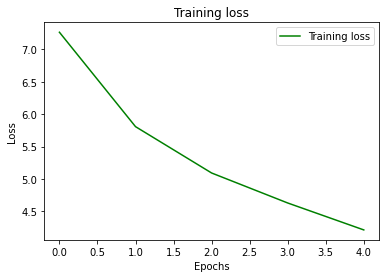

In [53]:
plt.plot(list(range(len(train_losses))), train_losses, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save Trained Model

In [58]:
file_path_4 = '/scratch/jw6254/unziptest/pkl_files/trained_model.pkl'

with open(file_path_4, 'wb') as handle:
    pickle.dump(network, handle)

## Validation
Freeze the weights for Validataion Loss

In [78]:
# Making Network Weights untrainable and checking
for layer in network.layers:
    layer.trainable = False
network_train.compile(loss=None,optimizer=optimizer)

In [79]:
validation_losses = run_training(1, test_val_batched)

  0%|          | 0/1 [00:00<?, ?it/s]

Starting training process!
-------------------------------------
--------- Epoch:  1 ---------
Epoch:  1 Batch:  0 Batch Loss:  4.033597
Epoch:  1 Batch:  1 Batch Loss:  4.033597
Epoch:  1 Batch:  2 Batch Loss:  4.033597
Epoch:  1 Batch:  3 Batch Loss:  4.033597
Epoch:  1 Batch:  4 Batch Loss:  4.033597
Epoch:  1 Batch:  5 Batch Loss:  4.033597
Epoch:  1 Batch:  6 Batch Loss:  4.033597
Epoch:  1 Batch:  7 Batch Loss:  4.033597
Epoch:  1 Batch:  8 Batch Loss:  4.033597
Epoch:  1 Batch:  9 Batch Loss:  4.033597
Epoch:  1 Batch:  10 Batch Loss:  4.033597
Epoch:  1 Batch:  11 Batch Loss:  4.033597
Epoch:  1 Batch:  12 Batch Loss:  4.033597
Epoch:  1 Batch:  13 Batch Loss:  4.033597
Epoch:  1 Batch:  14 Batch Loss:  4.033597
Epoch:  1 Batch:  15 Batch Loss:  4.033597
Epoch:  1 Batch:  16 Batch Loss:  4.033597
Epoch:  1 Batch:  17 Batch Loss:  4.033597


100%|██████████| 1/1 [00:14<00:00, 14.79s/it]

Epoch:  1 Batch:  18 Batch Loss:  4.033597




## From the Trained Network Need to get the Fingerprint per Song

In [82]:
def format_for_fingerprinting(anchor, x_size, y_size):

    n_rows = anchor[0].shape[0]
    n_cols = anchor[0].shape[1]

    total_list = []
    for i in tqdm(range(len(anchor))):
        random_indices_rows = np.random.choice(n_rows, size=x_size, replace=False)
        random_indices_cols = np.random.choice(n_cols, size=y_size, replace=False)

        temp_anchor = anchor[i][random_indices_rows, :][:, random_indices_cols]
        anc = np.reshape(temp_anchor, (1, x_size, y_size, 1))
        
        total_list.append(anc)

    return total_list

In [83]:
to_be_fingerprinted = format_for_fingerprinting(achor_train_list, test_reduced_x_dim, test_reduced_y_dim)

100%|██████████| 7000/7000 [00:09<00:00, 767.83it/s]


## Checking to see if its correctly formatted

In [84]:
len(to_be_fingerprinted), to_be_fingerprinted[0].shape

(7000, (1, 50, 50, 1))

## Fingerprint for every Song

In [87]:
def fingerprinter(anchor):

    total_list = []
    for i in tqdm(range(len(anchor))):
        total_list.append(network.predict(anchor[i]))

    return total_list

In [88]:
fingerprint_output = fingerprinter(to_be_fingerprinted)

100%|██████████| 7000/7000 [22:56<00:00,  5.08it/s]


In [91]:
fingerprint_output

[array([[-0.24887267, -0.2628665 ,  0.2135139 ,  0.05188239, -0.04519863,
          0.32645777, -0.22363631, -0.53983784,  0.039849  , -0.60748667]],
       dtype=float32),
 array([[-0.5026539 ,  0.56221795, -0.51540995, -0.24255535, -0.10223176,
          0.1128163 , -0.17855975, -0.09183715, -0.20797583,  0.0043673 ]],
       dtype=float32),
 array([[-0.1491055 , -0.3390747 ,  0.04234421,  0.1769227 , -0.19542816,
          0.21889766, -0.2652732 , -0.80378973,  0.03228251, -0.16156377]],
       dtype=float32),
 array([[ 0.09256621, -0.12434705,  0.09054672, -0.08207006, -0.42495027,
          0.48459002,  0.14953779, -0.41429308, -0.05763947, -0.5901715 ]],
       dtype=float32),
 array([[ 0.09715338, -0.25594425,  0.06705219,  0.02557195, -0.24758027,
          0.48749676,  0.00314103, -0.66057056,  0.00129942, -0.42963904]],
       dtype=float32),
 array([[ 0.11768306, -0.63498557,  0.5056879 ,  0.08129866, -0.22741993,
         -0.13959298,  0.10712503, -0.36516467,  0.14270768, 

In [90]:
file_path_5 = '/scratch/jw6254/unziptest/pkl_files/finger_printed_log_mel_spec.pkl'

with open(file_path_5, 'wb') as handle:
    pickle.dump(fingerprint_output, handle)

## Running Another Network With Pretrained Weights

In [ ]:
network_pretrained = build_network(input_shape,embeddingsize=10)
network_train_2 = build_model(input_shape,network_pretrained)
optimizer = Adam(lr = 0.00006)
network_train_2.compile(loss=None,optimizer=optimizer)
network_train_2.summary()
# plot_model(network_train,show_shapes=True, show_layer_names=True,)
# print(network_train.metrics_names)

network_train_2.load_weights('mnist-160k_weights.h5')